## **Logistic Regression Example**

Keeping the above assumptions in mind, let’s look at a dataset. The dataset is the success rate of people applying for a specific position. Each candidates Graduate Management Admission Test score, GPA score and work expreience were also recorded. The aim of this analyis is to determine which variables should be used when making a decision to accept or reject a candidate.

We will read the data into a dataframe called candidates and this is outlined below:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

candidates = {'gmat': [780,750,690,710,680,730,690,720,740,690,610,690,710,680,770,610,580,650,540,590,620,600,550,550,570,670,660,580,650,660,640,620,660,660,680,650,670,580,590,690],
              'gpa': [4,3.9,3.3,3.7,3.9,3.7,2.3,3.3,3.3,1.7,2.7,3.7,3.7,3.3,3.3,3,2.7,3.7,2.7,2.3,3.3,2,2.3,2.7,3,3.3,3.7,2.3,3.7,3.3,3,2.7,4,3.3,3.3,2.3,2.7,3.3,1.7,3.7],
              'work_experience': [3,4,3,5,4,6,1,4,5,1,3,5,6,4,3,1,4,6,2,3,2,1,4,1,2,6,4,2,6,5,1,2,4,6,5,1,2,1,4,5],
              'admitted': [1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1]
              }
df = pd.DataFrame(candidates,columns= ['gmat', 'gpa','work_experience','admitted'])


df.describe()
#from google.colab import files
#df.to_csv('candidates.csv')
#files.download('candidates.csv')

gmat        gpa  work_experience   admitted
count   40.000000  40.000000        40.000000  40.000000
mean   654.000000   3.095000         3.425000   0.525000
std     61.427464   0.631218         1.737778   0.505736
min    540.000000   1.700000         1.000000   0.000000
25%    607.500000   2.700000         2.000000   0.000000
50%    660.000000   3.300000         4.000000   1.000000
75%    690.000000   3.700000         5.000000   1.000000
max    780.000000   4.000000         6.000000   1.000000

We have now imported the data and printed a summary analysis of the data using the Pandas "describe" method. By doing this we can easily see that the problems is well balanced between accept and reject for the admitted variable. This is very convenient, as normally this would not be the case. When problems are imbalanced we should really deal with this as part of the problem. 

The next thing you will have noticed is the mean response for the 3 independent varibles which are as follows:
>gmat |	gpa |	work_experience 
>--- | --- | --- 
>654.00	| 3.095	| 3.425	

We can see that the gpa and work_experience variables are of a similar scale but gmat is a factor of 100 greater. Many people when starting out in their analytics journey feel the need to standardise their data as a preprocessing step. This is not necessary if you are dealing with a linear model, as we are not using complex optimisation routines. We will look at differing methods to standardise data in the next MOOC but **in the case of logistic or linear regression there is absolutely no need to standardise your independent variables**. In fact if you do this you will be actually reduce the volume of information from your model, thus reducing the models predictive power.

You may want to center your independent variables as this may improve the interpretation of the intercept. When you center a variable the intercept becomes the mean of the Y variable at the value you centered on, but importantly the slopes/paremeter estimates will not change. But for this logistic model we will find that model will fail as well get "perfect seperation". This is usually caused by over specification of the model (To many variables). Try it out and see what happens. See if you can get results using 2 variables and no intercept. What do you notice about the p-values. 

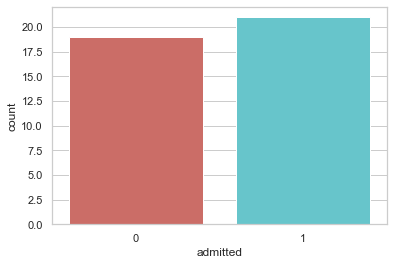

<Figure size 432x288 with 0 Axes>

In [3]:
#df['gmat_t']=(df['gmat']-df['gmat'].min())/(df['gmat'].max()-df['gmat'].min())
#print(df['gmat_t'])
#df['gpa']=df['gpa']-df['gpa'].mean()
#df['work_experience']=df['work_experience']-df['work_experience'].mean()
#df['gmat']=df['gmat']-df['gmat'].mean()
sns.countplot(x='admitted',data=df,palette='hls')
plt.show()
plt.savefig('count_plot')

We see from the above histogram that the "admitted" variable is well balanced. Generally, we should really complete a number of plots and a correlation analysis to examine the relationship between variables. If 2 variables are highly correlated then it is appropriate to drop one of these variables from the model.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


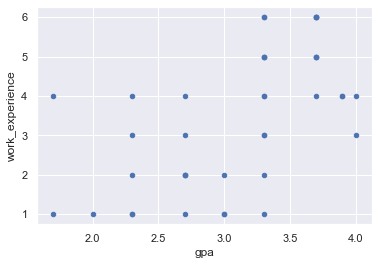

In [4]:
sns.set()
%matplotlib inline
df.plot.scatter(x='gpa', y='work_experience')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


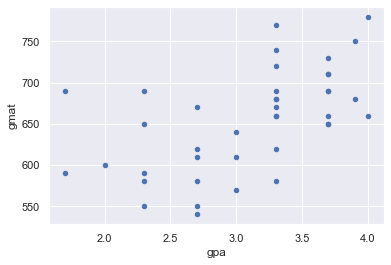

In [5]:
sns.set()
%matplotlib inline
df.plot.scatter(x='gpa', y='gmat')

In [6]:
corr = df[['gpa','work_experience','gmat']].corr()
corr.style.background_gradient(cmap='coolwarm')

The 3 independent variables do appear to have some correlation between them, but we cannot be sure how this will affect our model. In order to assess this we should really examine the multi-collinearity between all the independent variables. The code below shows how we can assess multi-collinearity using a term known as the "variance inflation factor" or VIF. VIF is calculated by regressing a independent variable against all the other variables and using the following formula:
$$ V.I.F. = 1 / (1 - R^2). $$

If your VIF factor is >10 then you really need to consider dropping variables from your model. In the example below we can see that the following equations give the VIF calculated from the code:

<br/>

$gmat=\alpha{} + \beta{}_1.gpa +\beta{}_2.workexperience$ gives a VIF of 1.88

$gpa=\alpha{} + \beta{}_1.gmat +\beta{}_2.workexperience$ gives a VIF of 1.54

$workexperience=\alpha{} + \beta{}_1.gpa +\beta{}_2.gmat$ gives a VIF of 1.47

<br/>

While gmat and gpa only had a correlation coefficent of 0.56 which is not excessively high we see that the there is little multi-collinearity between the variables. 


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
X=df[['gpa','work_experience','gmat']]
X = add_constant(X)
y=df['admitted']
vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])

[1.8853631251353056, 1.5432670558547887, 1.4784366660764858]


Now we will run a number of logistic regression models and see which ones make most sence.

In [8]:
import statsmodels.api as sm
 
import statsmodels.discrete.discrete_model as sml
X=df[['gpa','gmat','work_experience']]
#X=df[['gpa','work_experience']]
#X = add_constant(X)
#X=df[['work_experience']]
logit = sml.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.295370
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               admitted   No. Observations:                   40
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Mar 2020   Pseudo R-squ.:                  0.5731
Time:                        22:14:11   Log-Likelihood:                -11.815
converged:                       True   LL-Null:                       -27.676
Covariance Type:            nonrobust   LLR p-value:                 1.293e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gpa                 3.4646      1.618      2.142      0.032       0.294       6.635
gmat          

*   Pseudo R-squ. is similar to the $R^2$ in linear regression
*   LLR p-value: tells if the model is significantly better than a null model
* The confusion matrix tells which categories are more likely to be predicted correctly and incorectly.

Now by interchanging GPA, GMAT and the intercept we get differing values for the Rseudo $R^2$ or none at all as the model fails. In order to determine which model is most appropriate we would take the  Pseudo $R^2$, the pvalues and the LLR pvalue into account. We would then examine the Accuarcy, F1-score and the Area under the curve. Sometimes it is a tough call but in this situation we would probably use the gmat, gpa and work_experience variables with no intercept, as they give the  highest $R^2$ and LLT P-value is highly significant. However, the coeffficent of the GMAT variable is in the wrong direction. You will notice that it is negative. This tells us that it has a slight negative impact on the odds of being admitted. You will also notice if you leave the GMAT variable out that the coeficent for GPA swaps diection. 



Another, issue is we do not have a intercept. You will see that if you swap the intercept with the gmat variable we get a Pseudo $R^2$ of 1. Also when we examine the Accuracy of this model we get a perfect score. One needs to be very careful when picking a model like this as you cannot be sure that the this model would scale very well. A real point to be worried about with this model is the size of the standard errors for all the variables including the intercept.

You could argue that if you have a zero GPA, GMAT and work experience then you would expect the odds of being addmitted being zero. 

If you add a constant into the model you will find that it fails. This usually occurs because the model is overspecified or unstable, and can mean that a number of variables/predictors are highly correlated with the intercept, or you have to many variables in the model or the dataset is to small. 

Also, most importantly you will notice the standard error inflates dramitically when we include an intercept, thus we cannot definitively tell which variables are useful. Taking all of this evidence into account would suggest we ignore the intercept term.

We will now examine the accuracy, F1 score and the AUC. 

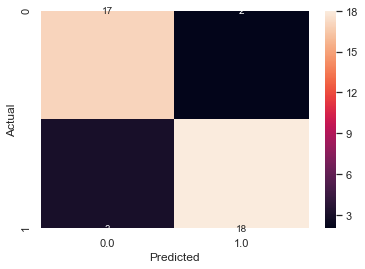

In [9]:
confusion_matrix = pd.crosstab(y, np.round_(logit.predict(),0), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In the following code window we can run a clasification report which gives a number of statistics. The explaination for these statistics is as follows:

* accuracy (correct decisions/total no. of decisions)
* precision (True positives/(True Positives+False Positivies))
* recall (True positives/(True Positives + False Negatives)) 
* f1-scrore (Formula including precision and recall) 
* support (The number of items in the class)

In classification problems we need to be very careful not to over rely on the accuracy score. It can often be the case that a high accuracy could be found, however, we may need to put more emphasis on identifying a particular class. So for example if we were trying to identify critically ill patients from a rare disease we would most likely get a high accuaracy as we would identify the majority of patients who were not ill, but diagnose someone as not being ill when in fact they are seriously ill. This is the reason why some authors report a F1-score. However, this to has been criticized has it treats precision and recall equally.  


In [10]:
from sklearn.metrics import classification_report
print(classification_report(y, np.round_(logit.predict(),0)))

precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.90      0.86      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40



Finally for logistic regression models we should build a Receiver Operating Characteristic (ROC) curve and determine the Area Under the Curve (AUC)
A ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings. The higher the AUC the better the classifier.

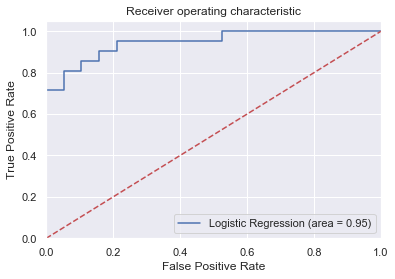

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y, logit.predict(X))
fpr, tpr, thresholds = roc_curve(y, logit.predict(X))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

So we have only really shown how to run the logistic model, but we have not really examined the formula for it or the interpretation of the parameter estimates. We will address these issues in MOOC5 when we introduce the theory behind Generalised Linear Model.

Finally, you will all want to try to predict class or continous variables. If you are doing this run the models on a "training" set. This is a subset of your data that your models will be trained on. The remaining part of the data will be treated as a test set. When your model is finalised on the training set you will then test it on your test set. There are a number of ways to select training and test sets and you always have to make sure they are properly balanced. You will learn a lot more about this in Machine Learning.